# CA2 - ML on Agriculture in Ireland and EU

## Overview

Sentiment analysis on data x

2 ML models on data y

...

## Auxiliary Functions

In this section, the auxiliary functions used in this notebook were implemented.

<b>Requirements:</b>

* Instructions to perform the sentiment analysis:

    - NLTK library should be installed


* Instructions to use the Twitter API:

    - There should exist a file called .twitter_env in the machine's home directory with the following keys:

        ```
        API_KEY=***
        API_KEY_SECRET=***
        BEARER_TOKEN=***
        ```

In [274]:
# !pip install textblob
# !pip install punkt
# !pip install python-dotenv
# import nltk
# nltk.download()
from dotenv import dotenv_values
from pathlib import Path
from os import listdir
import os
import re
import json
import string
import logging
import warnings
import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt

from textblob import TextBlob 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# ignore warnings
warnings.filterwarnings('ignore')

# use a logger to help debugging
logger = logging.getLogger('mylogger')
# set logger level
logger.setLevel(logging.ERROR)

# path to the current directory
CURR_PATH = os.path.abspath(os.getcwd())
# path to the users directory
HOME_DIR = str(Path.home())
# path to dataset dir
DATASET_DIR = os.path.join(CURR_PATH, 'datasets')

# twitter env file
TWITTER_ENV_FILE = '.twitter_env'

class HttpConnect:
    config = None

    def __init__(self, config):
        self.config = config

    def get_bearer_auth(self, r):
        """
        Method required by bearer token authentication.
        """
        if self.config is None:
            raise Exception('Unable to create Bearer authorization object.')

        r.headers['Authorization'] = f"Bearer { self.config['BEARER_TOKEN'] }"
        r.headers['User-Agent'] = 'v2RecentSearchPython'

        return r

    def connect_endpoint(self, url, params_dict={}):
        response = requests.get(url, auth=self.get_bearer_auth, params=params_dict)

        if response is None:
            raise Exception('Invalid response.')

        logger.info(response.status_code)

        if response.status_code != 200:
            raise Exception(response.status_code, response.text)

        return response.json()

class TwitterApi(HttpConnect):
    # twitter recent search api url
    TWITTER_API_SEARCH_URL = 'https://api.twitter.com/2/tweets/search/recent'

    last_response = None
    config = None

    def __init__(self, config):
        """
        The constructor for TwitterApi class.

        Parameters:
            auth (auth): Authentication parameters. 
        """
        HttpConnect.__init__(self, config)

    def search_tweets(self, params={}, max_pages=10):
        tweets_list = []
        if self.run_request(self.TWITTER_API_SEARCH_URL, params):
            tweets_list, next_token = self.extract_tweets()
            count=1
            if next_token is not None and count < max_pages:
                url = f'{ self.TWITTER_API_SEARCH_URL }?next_token={next_token}'
                if self.run_request(url, params):
                    next_tweets_list, next_token = self.extract_tweets()
                    tweets_list+= next_tweets_list
                    count+=1
                else:
                    next_token = None

        print(f"{ len(tweets_list) } tweets retrieved!")

        return tweets_list
    
    def run_request(self, url, params={}):
        ret = False
        try:
            self.last_response = self.connect_endpoint(url, params)
            ret = True
        except Exception as e:
            logger.error(e)
        return ret

    def parse_response(self):
        resp = self.last_response        

        meta = None
        if 'meta' in resp.keys():
            meta = resp['meta']
        
        data = None
        if 'data' in resp.keys():
            data = resp['data']

        return meta, data

    def extract_tweets(self):
        meta, data = self.parse_response()
        
        if meta is None or data is None:
            return [], None
        
        tweets_set = set()
        for t in data:
            tweets_set.add(t['text'])

        tweets_list = list(tweets_set)
        next_token = None
        if 'next_token' in meta.keys():
            next_token = meta['next_token']

        return tweets_list, next_token
        
    def save_result_to_file(self, outfile):
        json_helper = JsonHelper(self.last_response)
        json_helper.to_file(outfile)

class JsonHelper:
    json_data = {}
    
    def __init__(self, json_data):
        self.json_data = json_data

    def to_file(self, outfile):
        if len(outfile) == 0:
            logger.warning('Output filename is empty!')
            return

        with open(outfile, 'w', encoding='utf-8') as f:
            json.dump(self.json_data, f, ensure_ascii=False, indent=4)

    def to_string(self):
        return json.dumps(self.json_data, indent=4, sort_keys=True, ensure_ascii=False)

class TextProcessor:
    use_stemmer = False
    use_lemmatizer = False
    
    def __init__(self, stemmer=False, lemmatizer=False):
        self.use_stemmer = stemmer
        self.use_lemmatizer = lemmatizer
        
    def process_text(self, text):
        text = self.clean_text(text)
        
        tokens = self.get_tokens(text)
        filtered_words = self.filter_stop_words(tokens)

        if self.use_stemmer:
            filtered_words = self.apply_stemmer(filtered_words)

        if self.use_lemmatizer:
            filtered_words = self.apply_lemmatizer(filtered_words)

        return " ".join(filtered_words)
    
    def clean_text(self, text):
        # convert to lower case
        text = text.lower()
        # remove urls
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        # remove user @ references and '#' from text
        text = re.sub(r'\@\w+|\#','', text)
        # removing special chars
        text = re.sub('[^a-zA-Z]', ' ', text)
        # remove punctuations
        text = text.translate(str.maketrans('', '', string.punctuation))
        return text

    def get_tokens(self, text):
        return word_tokenize(text)

    def filter_stop_words(self, tokens=[]):
        stop_words = set(stopwords.words('english'))
        filtered_words = [w for w in tokens if not w in stop_words]
        return filtered_words

    def apply_stemmer(self, tokens=[]):
        ps = PorterStemmer()
        stemmed_words = [ps.stem(w) for w in tokens]
        return stemmed_words

    def apply_lemmatizer(self, tokens=[]):
        lemmatizer = WordNetLemmatizer()
        lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in tokens]
        return lemma_words
    
    @staticmethod
    def get_sentiment(text):
        res = TextBlob(text).sentiment.polarity        
        if res < 0:
          return 'negative'
        elif res > 0:
          return 'positive'
        return 'neutral'
    
def get_env_map():
    env_path = os.path.join(HOME_DIR, TWITTER_ENV_FILE)

    if not os.path.exists(env_path):
        logger.error(F'Unable to read the environment file. Make sure a { TWITTER_ENV_FILE } file exists in your home directory.')
        return None

    return dotenv_values(env_path)

def process_tweets(tweets_list):
    proc_tweets = []
    for i in range(0, len(tweets_list)):
        # raw tweet
        tweet_raw = tweets_list[i]
        sentiment_raw = TextProcessor.get_sentiment(tweet_raw)
        
        # cleaned tweet
        tweet_clr = TextProcessor().process_text(tweet_raw)
        sentiment_clr = TextProcessor.get_sentiment(tweet_clr)
        
        # steemed tweet
        tweet_st = TextProcessor(stemmer=True).process_text(tweet_raw)
        sentiment_st = TextProcessor.get_sentiment(tweet_st)

        # lemmatized tweet
        tweet_lm = TextProcessor(lemmatizer=True).process_text(tweet_raw)
        sentiment_lm = TextProcessor.get_sentiment(tweet_lm)

        proc_tweets.append((tweet_raw, sentiment_raw, tweet_clr, sentiment_clr, tweet_st, sentiment_st, tweet_lm, sentiment_lm))

    tweets_df = pd.DataFrame(proc_tweets, columns=['tweet_raw', 'sent_raw', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'])

    return tweets_df

def get_freq(df, colname):
    tokens_lst = []
    for i in range(0, len(df)):
        text = df.loc[i][colname]
        tokens_lst+= TextProcessor().get_tokens(text)

    fdist = FreqDist(tokens_lst)

    return fdist

## Sentiment Analysis

In this section, the Twitter API was used to collect tweets from the last few days that will be used for the sentiment analysis.

The purpose of this search was to find tweets about inflation or food price, which relate to the agriculture topic.

However, there is a limitation in the quality of data being collected as the query API feature performs a search by token which can result in tweets about any topic.

### Data Preparation

In [275]:
# retrieving tweets according to the query
start_date = datetime.datetime.now() - datetime.timedelta(30)
query_params = {
    'query' : '(inflation OR "food price" OR "agriculture") Europe -is:retweet -has:media lang:en',
    #'query' : 'food price agriculture -is:retweet -has:media lang:en',
    'tweet.fields': 'author_id', 
    'user.fields': 'name',
    'max_results': '100'
}

twitter_api = TwitterApi(get_env_map())
tweets_list = twitter_api.search_tweets(query_params)
tweets_df = process_tweets(tweets_list)
tweets_df.head()

200 tweets retrieved!


,tweet_raw,sent_raw,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm
0,British public were treated like mugs..lied to...,negative,british public treated like mugs lied sold riv...,neutral,british public treat like mug lie sold river p...,positive,british public treated like mugs lied sold riv...,positive
1,EU economies set to contract in 2023 - Financi...,positive,eu economies set contract financial times acco...,positive,eu economi set contract financi time accord ex...,positive,eu economies set contract financial times acco...,positive
2,Big big good news for all #Europe and #USA in ...,negative,big big good news europe usa cold season natur...,positive,big big good news europ usa cold season natura...,positive,big big good news europe usa cold season natur...,positive
3,"""The measures, coupled with an agreement negot...",positive,measures coupled agreement negotiated european...,positive,measur coupl agreement negoti european union p...,negative,measures coupled agreement negotiated european...,positive
4,It was due to the problems of Europe (Covid-19...,positive,due problems europe covid russia ukraine war r...,positive,due problem europ covid russia ukrain war rece...,positive,due problems europe covid russia ukraine war r...,positive


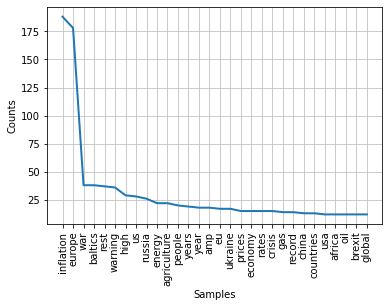

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [279]:
# display the frequency distribution
fdist = get_freq(tweets_df, 'tweet_clr')
fdist.plot(30, cumulative=False)

### Naive Bayes Classifier - Count Vectorizer

In [306]:
# add code to compare diff - lm, clr and st -> lm gave better results (both naive bayes approaches)
X = tweets_df['tweet_lm']
y = tweets_df['sent_lm']

# converting sentiment values to numbers
sentiment_ordering = ['negative', 'neutral', 'positive']

# store all values into column named as "y"
y = y.apply(lambda x: sentiment_ordering.index(x))

X.head(), y.head()

(0    british public treated like mugs lied sold riv...
 1    eu economies set contract financial times acco...
 2    big big good news europe usa cold season natur...
 3    measures coupled agreement negotiated european...
 4    due problems europe covid russia ukraine war r...
 Name: tweet_lm, dtype: object,
 0    2
 1    2
 2    2
 3    2
 4    2
 Name: sent_lm, dtype: int64)

In [307]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate an object cv by calling a method named as CountVectorzer()
cv = CountVectorizer(max_features = 5000)

# Train the dataset by calling a fit_transform() method
X_fin = cv.fit_transform(X).toarray()

# Display the rows and colums
X_fin.shape

(200, 1547)

In [308]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Instantiate an object model by calling a method MultinomialNB()
model = MultinomialNB()

In [309]:
# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X_fin, y, test_size=0.3)

In [310]:
# Train the model by calling a method fit()
model.fit(X_train, y_train)

MultinomialNB()

In [311]:
# Call predict() method
y_pred = model.predict(X_test)

In [312]:
from sklearn.metrics import classification_report

# Instantiate a mthod named as Cla
cf = classification_report(y_test, y_pred)

# Display the values of an object cf
print(cf)

              precision    recall  f1-score   support

           0       0.61      0.55      0.58        20
           1       0.48      0.67      0.56        15
           2       0.52      0.44      0.48        25

    accuracy                           0.53        60
   macro avg       0.54      0.55      0.54        60
weighted avg       0.54      0.53      0.53        60



### Naive Bayes Classifier - TfIdf Vectorizer

In [313]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an object 'tf' by calling a method TfidfVectorizer()
tfidf = TfidfVectorizer(max_features = 5000)

# Train the dataset by calling a method fit_tranform() 
X_tfidf = tfidf.fit_transform(X).toarray()

In [314]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Instantiate an object model by calling a method MultinomialNB()
model_tdidf = MultinomialNB()

In [315]:
# Split the dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3)

In [316]:
# Train the model by calling a method fit()
model_tdidf.fit(X_train, y_train)

MultinomialNB()

In [317]:
# Call predict() method
y_pred = model_tdidf.predict(X_test)

In [318]:
from sklearn.metrics import classification_report

# Instantiate a mthod named as Cla
cf = classification_report(y_test, y_pred)

# Display the values of an object cf
print(cf)

              precision    recall  f1-score   support

           0       0.60      0.21      0.32        14
           1       0.93      0.59      0.72        22
           2       0.54      0.92      0.68        24

    accuracy                           0.63        60
   macro avg       0.69      0.57      0.57        60
weighted avg       0.70      0.63      0.61        60



### Logistic Regression - Stemmer/Lemmatizer

In [320]:
# test logistic regression with stemmer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    return text.split()

def apply_lemmatizer(self, tokens=[]):    
    return [lemmatizer.lemmatize(w, pos='a') for w in tokens]

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

stop = stopwords.words('english')

In [321]:
# have to use cleaned data only - because grid search will try to apply lemmatizer and porter later
X_train = tweets_df.loc[:60, 'tweet_clr'].values
y_train = tweets_df.loc[:60, 'sent_clr'].values
X_test = tweets_df.loc[60:, 'tweet_clr'].values
y_test = tweets_df.loc[60:, 'sent_clr'].values

In [322]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, apply_lemmatizer],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, apply_lemmatizer],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [323]:
X_train.shape

(61,)

In [324]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=0))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1.0, 10.0, 100.0],
                          'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd",...
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                  

In [325]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each'

In [326]:
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.507
